# Apresentação:

O objetivo desse código é estudar sobre **modelagem de tópicos** no contexto de **_Natural Language Processing_** **(NLP)**, um tipo de modelagem usada para identificar temas ou tópicos ocultos em grandes coleções de documentos. A ideia geral é assumir que cada documento é composto por uma mistura de tópicos, e cada tópico é representado por um conjunto de palavras com probabilidades associadas. Aqui vamos focar em dois modelos o **_Latent Dirichlet Allocation_** **(LDA)**, um **modelo de Variável Latente** **(_latent variable model_ - LVM)**, um modelo probabilístico em que algumas variáveis estão sempre **latentes** ou **ocultas** e o **_non-negative matrix factorization_** **(NMF)**, um **Modelo de Fatores Latentes** (**_Latent Factor Models_ - LFM**), um caso especial de **LVM**'s que focam em **decomposições fatoriais**, geralmente com **fatores contínuos** usados para descrever os dados observáveis.

**Nota:** Não confundiar **_Latent Dirichlet Allocation_** com o modelo de classificação **_Linear Discriminant Analisys_**, ambos são **LDA**, mas por pura coincidência!

## Material Base:

O estudo aqui terá como fonte principal de código a própria [documentação do **sklearn**](https://scikit-learn.org/stable/index.html), biblioteca utilizada para a implementação dos modelos, com os livros sendo majoritáriamente como fonte de embasamento teórico dos modelos.

* **Probabilistic Machine Learning: An Introduction** de *Kevin P. Murphy*;
* **Probabilistic Machine Learning: Advanced Topics** de *Kevin P. Murphy*.

In [1]:
import os

In [2]:
# Pasta com os textos:
pasta = r'E:\Datasets\Textos\Textos em ingles'

# Cria uma lista para armazenar os paths dos arquivos .txt
arquivos_txt = []

# Percorre todos os arquivos da pasta
for nome_arquivo in os.listdir(pasta):
    # Verifica se o arquivo tem a extensão .txt
    if nome_arquivo.endswith('.txt'):
        # Adiciona o caminho completo do arquivo na lista
        arquivos_txt.append(os.path.join(pasta, nome_arquivo))
arquivos_txt

['E:\\Datasets\\Textos\\Textos em ingles\\texto1.txt',
 'E:\\Datasets\\Textos\\Textos em ingles\\texto2.txt',
 'E:\\Datasets\\Textos\\Textos em ingles\\texto3.txt']

In [3]:
# Extraindo textos:
documentos = []
for arquivo in arquivos_txt:
    with open(arquivo, 'r', encoding="UTF-8") as arq:
        documento = arq.readlines()
    documentos.append(documento)

In [4]:
# Verificando documentos:
for documento in documentos:
    print(documento[0])

One Monday afternoon, Mike, adopting a very unusual style, wore a hoody. Nobody would ever think of wearing a hoody on a very hot day. His friends also wondered why he was being weird. They became a little aloof with Mike that day. The next day, Mike wore a hoody again, this time of a different color. This went on every day for a week and his friends gradually got used to it. Finally, on the eighth day, Mike wore a plain white shirt, acting like nothing had been amiss for the past week. One of his friends asked him, “Are you finally done with your hoody fashion?” “What hoody fashion?” Mike asked. “Last week, everyday, you kept on wearing a hoody.” And then Mike said, “What? I was on vacation last week. I just got home this morning. ”
I woke up this morning not wanting to go to class. I told myself that being late would be okay since our first class would be Physical Education. We just play games the whole time, and my teacher would not notice if I come early or late. I stayed in bed fo

# Normalização dos dados:

Para essas técnicas probabilísticas, é interessante a normalização dos dados de texto, que consiste em 3 etapas principais:
* Tratar pontuações;
* Retirar *stop words*;
* Deixar *lowercase*;

Para que dai sim, se possa tokenizar. É uma etapa ardua, como vimos em estudos anteriores, todavia, por sorte, se torna um processo menos complexo com as ferramentas certas.

In [5]:
# Importando função:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords

# Stop words:
stop_words = stopwords.words('english')
#stop_words.append("would")
stop_words.extend(["would", "ate","since"]) # Extendendo as stop words.
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
# Primeira Etapa de Normalização:
tokenDoc = {}
for documento in documentos:
    # Limpa no a key:
    nome_documento = documento[0].replace('\ufeff', '').strip()
    
    # Inicializa o dicionário com o nome do documento limpo
    tokenDoc[nome_documento] = []
    
    for frase in documento:
        tokens = text_to_word_sequence(frase)
        if len(tokens) != 0:
            for word in tokens:
                # Verifica se a palavra não é uma stop word e é alfabética
                if word not in stop_words and word.isalpha():
                    tokenDoc[nome_documento].append(word)

## Latent Dirichlet Allocation (LDA):

Comumente conhecido como **modelo de mistura**, esse modelo é uma composição de **distribuições de *dichilet***.

Podemos definir o modelo **LDA** (_Latent Dirichlet Allocation_) da seguinte forma. Seja $x_{nl} \in \{1,..., V\}$ a identidade da $l$'ésima palavra no documento $n$, onde $l$ agora pode variar de $1$ a $L_n$, o comprimento do documento, e $V$ é o tamanho do vocabulário (o espaço vetorial). A probabilidade da palavra $v$ no local $l$ é dada por,

$$p(x_{nl}=v|\mathbf{z}_n)=\sum_{k}\mathcal{z}_{nk}w_{kv}$$ 

Onde $0 \le z_{nk} \le 1$ é a proporção de "topicos" "k" no documento $n$ e $z_n \sim \mathcal{Dir}(\boldsymbol{\alpha})$

Podemos então reescrever esse modelo associando uma **variável latente discreta** $m_{nl} \in \{1,...,N_z\}$ a cada palavra em cada documento, com probabilidade $p(m_{nl}|\mathbf{z}_n) = Cat(m_{nl}|\mathcal{z}_n)$. Assim, $m_{nl}$ especifica o tópico a ser usado para a palavra $l$ no documento $n$. $$p(\mathbf{x}_n, \mathbf{z}_n,\mathbf{m}_n)= \mathcal{Dir}(\mathbf{z}_n|\boldsymbol{\alpha})\prod_{t=1}^{L_n}\mathcal{Cat}(m_{nl}|\mathbf{z}_n)\mathcal{Cat}(x_{nl}|\mathbf{W}[m_{nl},:])$$

Onde $\mathbf{W}[m_{nl},:] = w_k$ é a distribuição sobre as palavras para o $k$'ésimo tópico. Uma outra forma de formalizar essa distribuição conjunta, forma que eu acho um pouco mais fácil de entender é, dado a imagem,

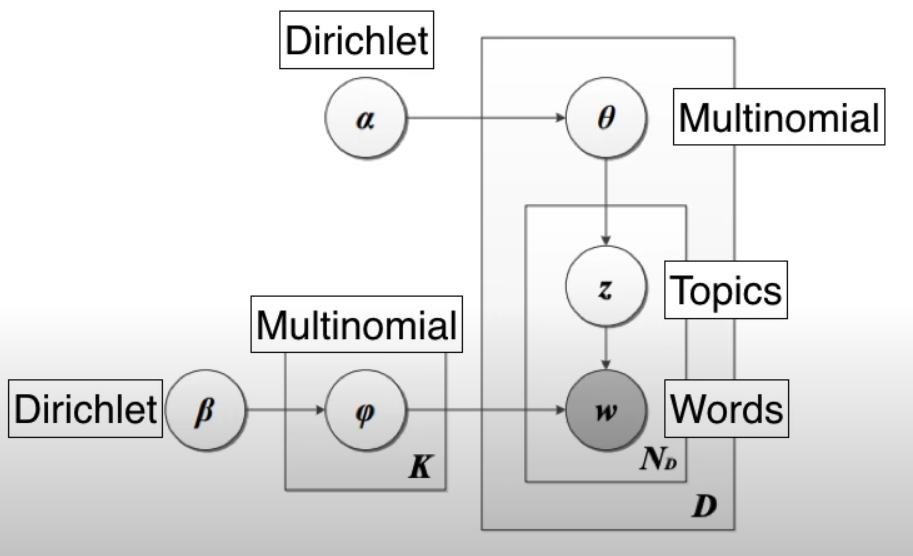

Onde:

* $W$ são as palavras observadas (no corpus), ou seja, a matriz de documentos-palavras;

* $Z$ são as variáveis latentes de tópicos para cada palavra;

* $\theta$ são as distribuições de tópicos por documento;

* $\phi$ são as distribuições de palavras por tópico;

* $\alpha$ e $\beta$ são hiperparâmetros da distribuição de Dirichlet.

De modo que,

$$p(\mathbf{W},\mathbf{Z},\boldsymbol{\theta}, \alpha, \beta)=\prod_{j=1}^{M}p(\theta_j,\alpha)\prod_{i=1}^{k}p(\phi_i,\beta)\prod_{t=1}^Np(Z_{j,t}|\theta_j)p(W_{j,t}|\phi z_{j,t})$$

Onde:
* $\prod_{j=1}^{M}p(\theta_j,\alpha)$ é o termo que representa a **distribuição de tópicos por documento**. Ele descreve como cada documento $j$ (onde $M$ é o número total de documentos) possui uma mistura de tópicos. A distribuição $\theta_j$ é amostrada de uma **distribuição de Dirichlet** parametrizada por $\alpha$, o hiperparâmetro que **controla a dispersão da distribuição**. Uma vez que a distribuição $\theta_j$ é amostrada, ela nos dá as proporções esperadas de tópicos dentro do documento $j$.
* $\prod_{i=1}^{k}p(\phi_i,\beta)$ é o termo que representa a **distribuição de palavras por tópico**. Para cada tópico $i$ (onde $k$ é o número de tópicos), a distribuição $\phi_i$ sobre palavras é amostrada de uma distribuição de Dirichlet parametrizada por $\beta$. Isso define quais palavras são mais prováveis de aparecer em um tópico específico.


* $\prod_{t=1}^Np(Z_{j,t}|\theta_j)p(W_{j,t}|\phi z_{j,t})$
    * $Z_{j,t}$ é a variável latente do tópico associada à palavra $t$ no documento $j$. Este termo define a probabilidade de escolher um tópico $Z_{j,t}$ para a palavra $W_{j,t}$ de acordo com a distribuição de tópicos $\theta_j$.
    * $W_{j,t}$ é a palavra observada que depende da distribuição de palavras $\phi$ do tópico $Z_{j,t}$. Ou seja, uma vez que um tópico $Z_{j,t}$ é escolhido, a palavra $W_j,t$ é gerada de acordo com a distribuição de palavras $\phi_{Z_{j,t}}$ associada a esse tópico.

In [223]:
from sklearn.decomposition import LatentDirichletAllocation

In [222]:
# Convertendo o dicionário de tokens para um formato de lista de strings
documentos_tokens = [' '.join(tokens) for tokens in tokenDoc.values()]

# Vetorizando os textos com CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2) # Não preciso do parâmtro de stop_words
contagem = vectorizer.fit_transform(documentos_tokens)
contagem.shape

(3, 6)

In [230]:
# Aplicando o modelo LDA
num_topicos = 3

# Instanciando Modelo:
lda_model = LatentDirichletAllocation(n_components=num_topicos, random_state=42)

# Ajustando Modelo:
lda_model.fit(contagem)

# Extraindo as palavras (vocabulário) do CountVectorizer
palavras = np.array(vectorizer.get_feature_names_out())

def mostrar_topicos(modelo, palavras, n_palavras):
    for index, topico in enumerate(modelo.components_):
        print(f"Tópico {index + 1}:")
        top_palavras = palavras[topico.argsort()[-n_palavras:]]
        print(", ".join(top_palavras))

mostrar_topicos(lda_model, palavras, 10)

Tópico 1:
day, also, looking, first, time, morning
Tópico 2:
looking, first, morning, time, also, day
Tópico 3:
morning, time, day, also, first, looking


In [229]:
# Avaliando o novo modelo
log_likelihood = lda_model.score(contagem)
perplexity = lda_model.perplexity(contagem)
print(f"Log-Likelihood: {log_likelihood}")
print(f"Perplexidade: {perplexity}")

Log-Likelihood: -37.84113686351913
Perplexidade: 10.644795145593989


## Non-negative matrix factorization (NMF):

O **NMF** (_Non-negative matrix factorization_) é uma 

# Factor Analisys no contexto de Modelagem de Tópicos:

**_Factor Anlasys_** ou **Análise Fatorial** é um tipo de modelagem no contexto de **aprendizado não supervisionado**, onde temos apenas do *dataset* $\mathbf{x}=\{x_1,...,x_n\}$. Um jeito simples de se modelar $\mathbf{x}$ é

$$x_i = Wh_i+\mu+\epsilon$$

O vetor $h_i$ é chamado de "_latent_" porque não é observado. $\epsilon$ é considerado ruído, um choque aleatório, com $\mu = 0$ e covariância $\Psi$, ou seja, $\epsilon \sim N(0,\Psi)$, em que $\mu$ é um vetor deslocamento arbitrário.

Tal modelo é chamado de "_generativo_" porque descreve como $x_i$ é gerado do $h_i$. Em notação matricial, considerando tomando todos os $x_i$'s, $h_i$'s, $\mu_i$'s e $\epsilon_i$'s em colunas de uma matriz, temos

$$\mathbf{X}=\mathbf{WH}+\mathbf{M}+\mathbf{E}$$

Ou seja, em outras palavras, **decompomos** $\mathbf{X}$.